In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

Количество столбцов равно 15

Проверим это и удалим строки, где количество столбцов меньше

In [2]:
sum = 0
with open('test_task_ml/data.txt', 'r') as outfile, open('new_data.txt', 'w') as infile:
    for line in outfile:
        line_length = len(line.split(','))
        if  line_length < 15: 
            sum += 1
            continue
        elif line_length == 15:
            infile.write(line)
print('Удалено строк: ', sum)

Удалено строк:  3


In [3]:
column_names = [
    'age',
    'workclass',
    'final_weight',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'cap-gain',
    'cap-loss',
    'hours-per-week',
    'native-country',
    'comparison' # условие того, получает ли человек больше или меньше указанной суммы  
    
]

In [4]:
dtypes = {
    'age': 'int32',
    'workclass': 'category',
    'final_weight': 'float64',
    'education': 'category',
    'education-num': 'int32',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'sex': 'category',
    'cap-gain': 'float64',
    'cap-loss': 'float64',
    'hours-per-week': 'int32',
    'native-country': 'category',
    'comparison': 'category'
}

In [5]:
train_data = pd.read_csv('new_data.txt', names=column_names, dtype=dtypes)

In [6]:
train_data.head()

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,comparison
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,<=N
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,<=N
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,<=N
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,<=N
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,<=N


In [7]:
train_data.dtypes

age                  int32
workclass         category
final_weight       float64
education         category
education-num        int32
marital-status    category
occupation        category
relationship      category
race              category
sex               category
cap-gain           float64
cap-loss           float64
hours-per-week       int32
native-country    category
comparison        category
dtype: object

In [8]:
for col in train_data.columns:
    print('Column name: ', col)
    print(train_data[col].unique())

Column name:  age
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
  1 87]
Column name:  workclass
[' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked']
Categories (9, object): [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ..., ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked']
Column name:  final_weight
[ 77516.  83311. 215646. ...  34066.  84661. 257302.]
Column name:  education
[' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ..., ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th']
Length: 16
Categories (16, object): [' Bachelors', ' HS-grad', ' 11th', ' Masters', ..., ' 10th', ' 1st-4th', ' Preschool', ' 12th']
Column name:  education-num
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Column name:  m

In [9]:
train_data.shape

(32571, 15)

Так как данная задача сводится к бинарной классификации, то заменим в исходе категориальные признаки следующим образом:

меньше N -> 0

больше N -> 1

In [10]:
new_train_data = train_data.copy()
le = LabelEncoder()
new_train_data['comparison'] = le.fit_transform(new_train_data['comparison'])

In [11]:
new_train_data.head()

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,comparison
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,0
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,0
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,0
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,0


In [12]:
train_data.isnull().sum()

age               0
workclass         0
final_weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
cap-gain          0
cap-loss          0
hours-per-week    0
native-country    0
comparison        0
dtype: int64

In [13]:
train_data.nunique()

age                  74
workclass             9
final_weight      21649
education            16
education-num        16
marital-status        7
occupation           15
relationship          7
race                  5
sex                   3
cap-gain            120
cap-loss             93
hours-per-week       95
native-country       42
comparison            2
dtype: int64

Как можно видеть в данном тренировочном наборе отсутствуют строки, где какой-либо признак имел значение NaN

Рассмотрим, как распределились записи в зависимости от класса >N или <=N

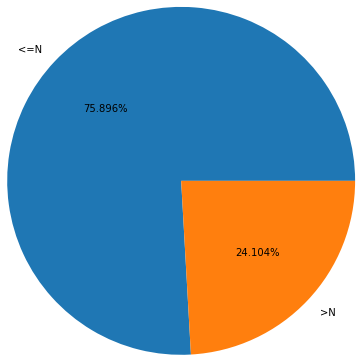

In [14]:
smaller, bigger = new_train_data['comparison'].value_counts()

plt.pie(x=[smaller, bigger], labels=['<=N', '>N'], autopct='%1.3f%%', radius=2)
plt.show()

Как можно видеть на круговой диаграмме тренировочный набор данных имеет сильное смещение в пользу класса <=N

Рассмотрим распределение значений в некоторых столбцах

In [15]:
from matplotlib.pyplot import figure

sns.set(rc={'figure.figsize':(20,15)})

<AxesSubplot:xlabel='age', ylabel='Count'>

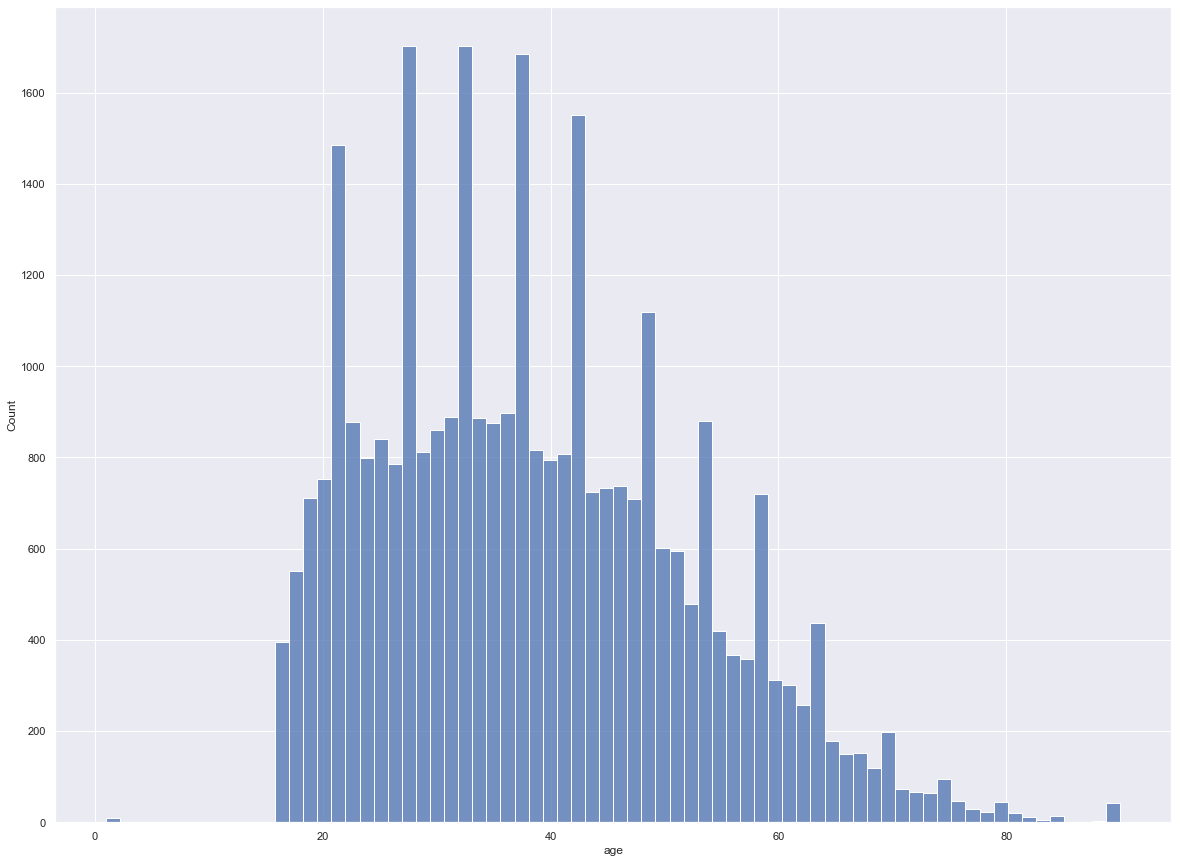

In [16]:
sns.histplot(data=new_train_data, x="age")

Можно видеть, что возраст некоторых опрошенных близко к 0.

Рассмотрим эти записи

In [17]:
new_train_data[new_train_data.age < 17]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,comparison
26555,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26556,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26557,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26558,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26559,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26560,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26561,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26562,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26563,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1
26564,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,-1911779654,United-States,1


Данные имеют некоторые аномалии, например возраст равен 1 и количество часов работы в неделю меньше 0.

Такие данные очень странные и их можно удалить из набора

In [18]:
new_train_data = new_train_data.loc[new_train_data['age'] >= 17]

In [19]:
new_train_data.age.unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47,
       46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58,
       26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82,
       83, 84, 85, 86, 87])

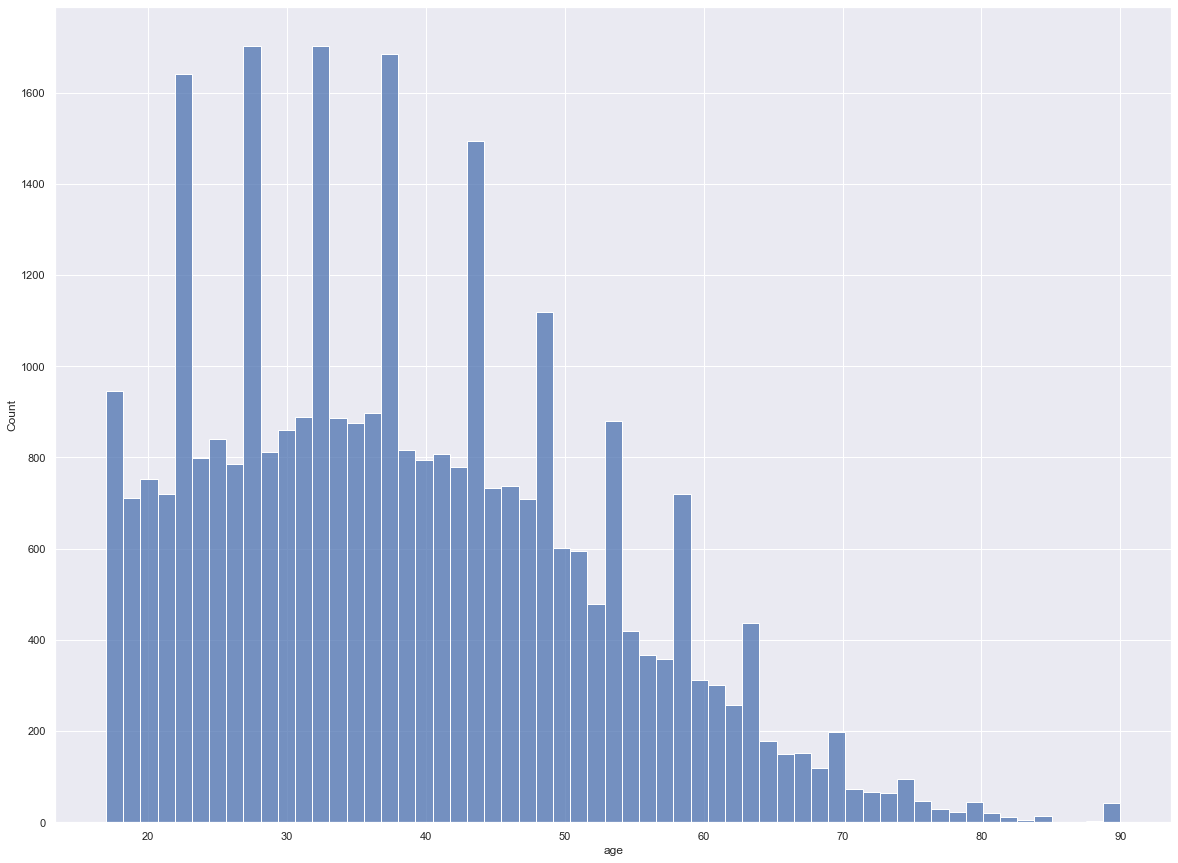

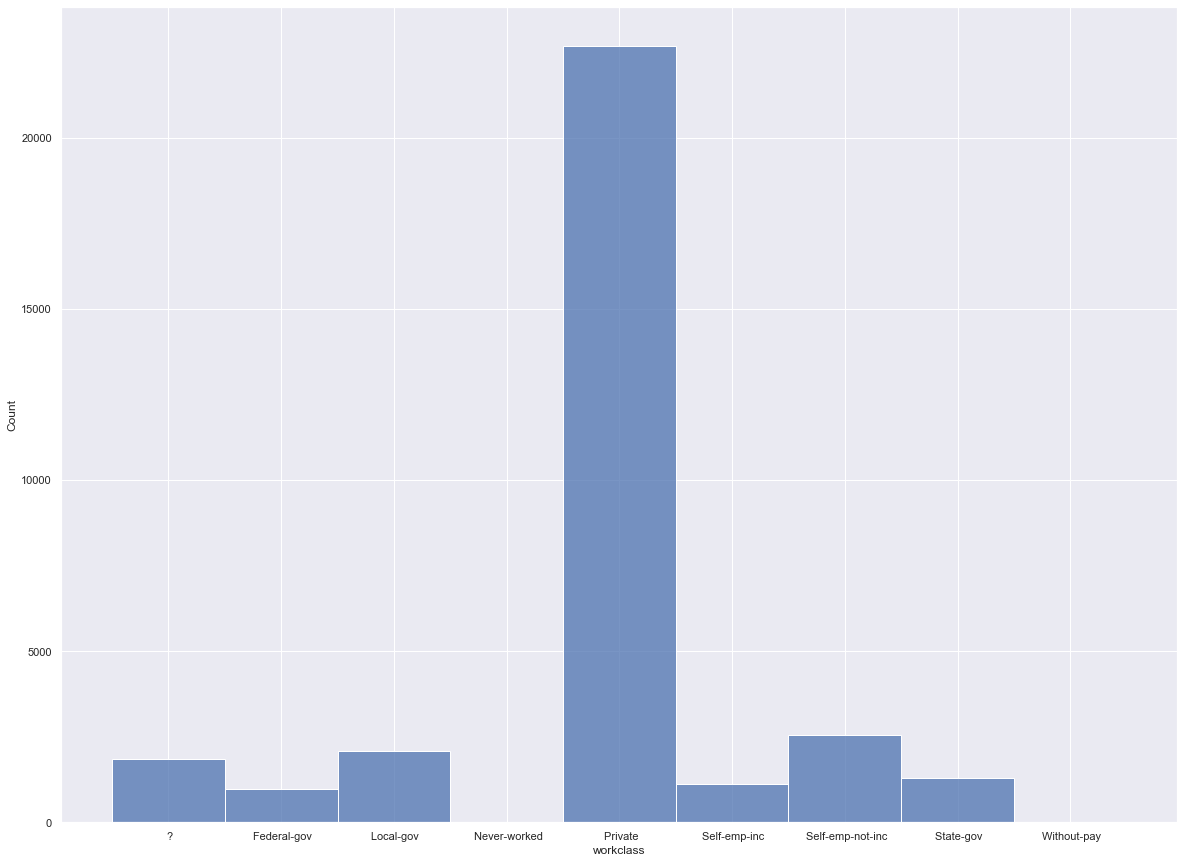

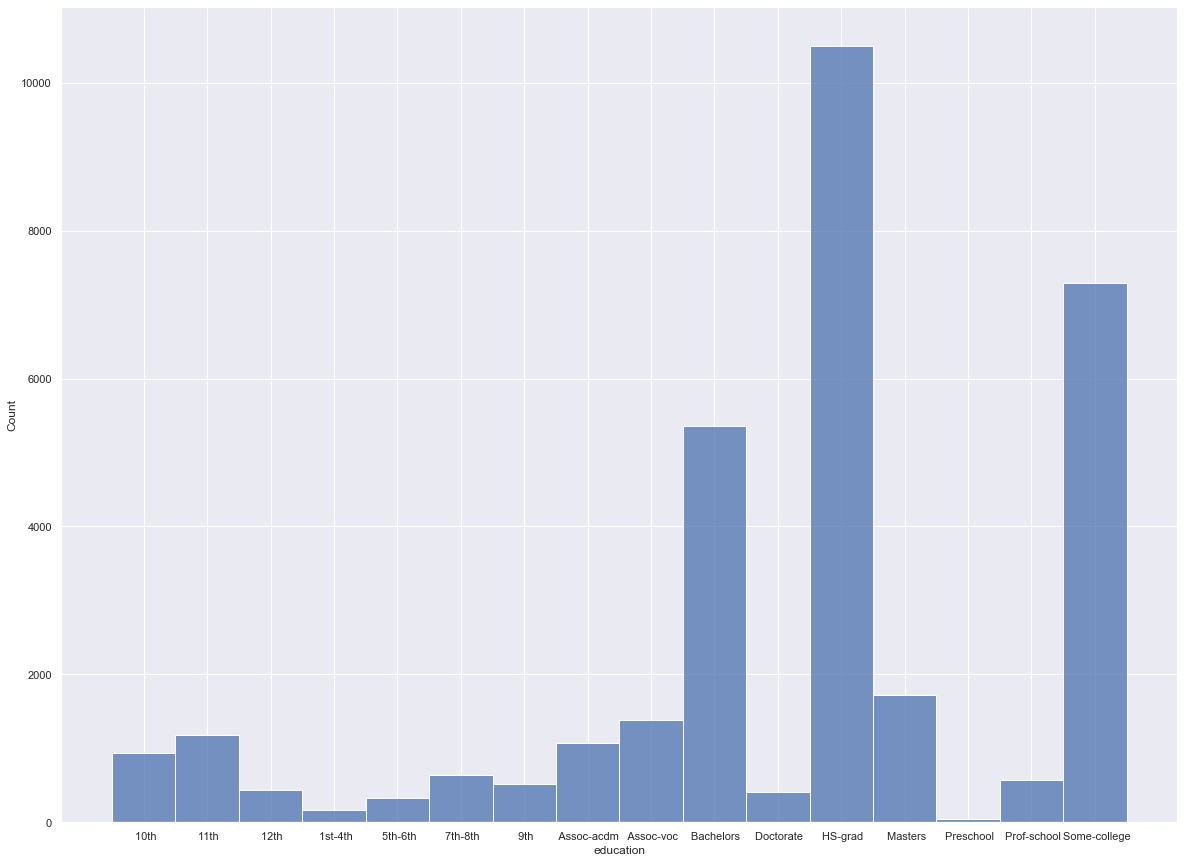

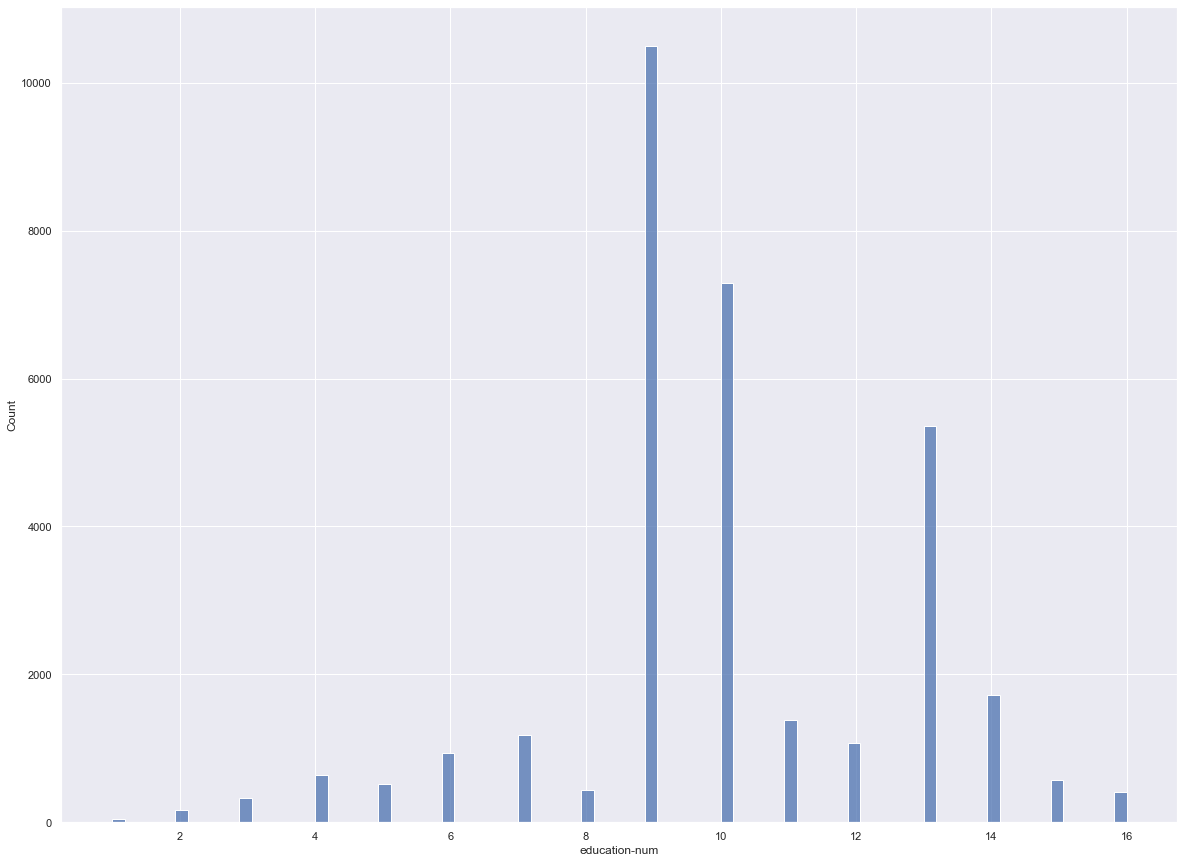

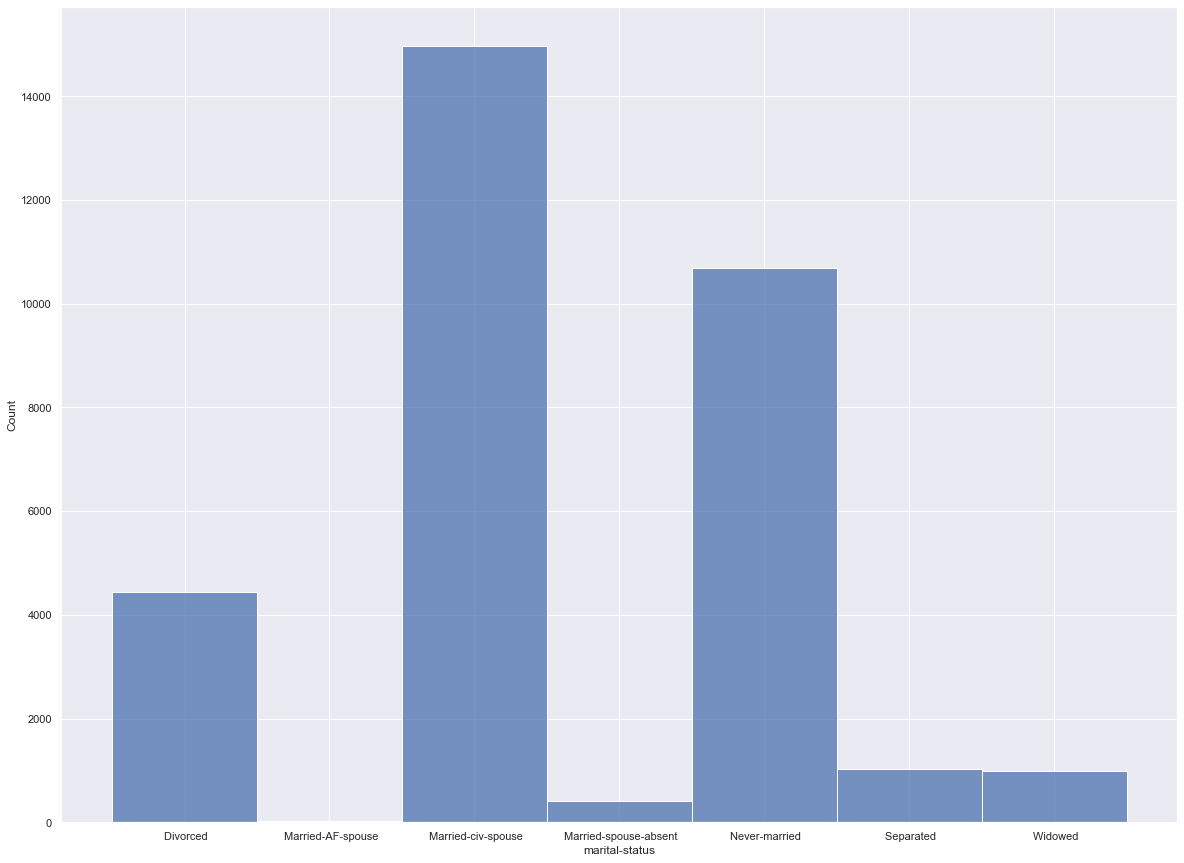

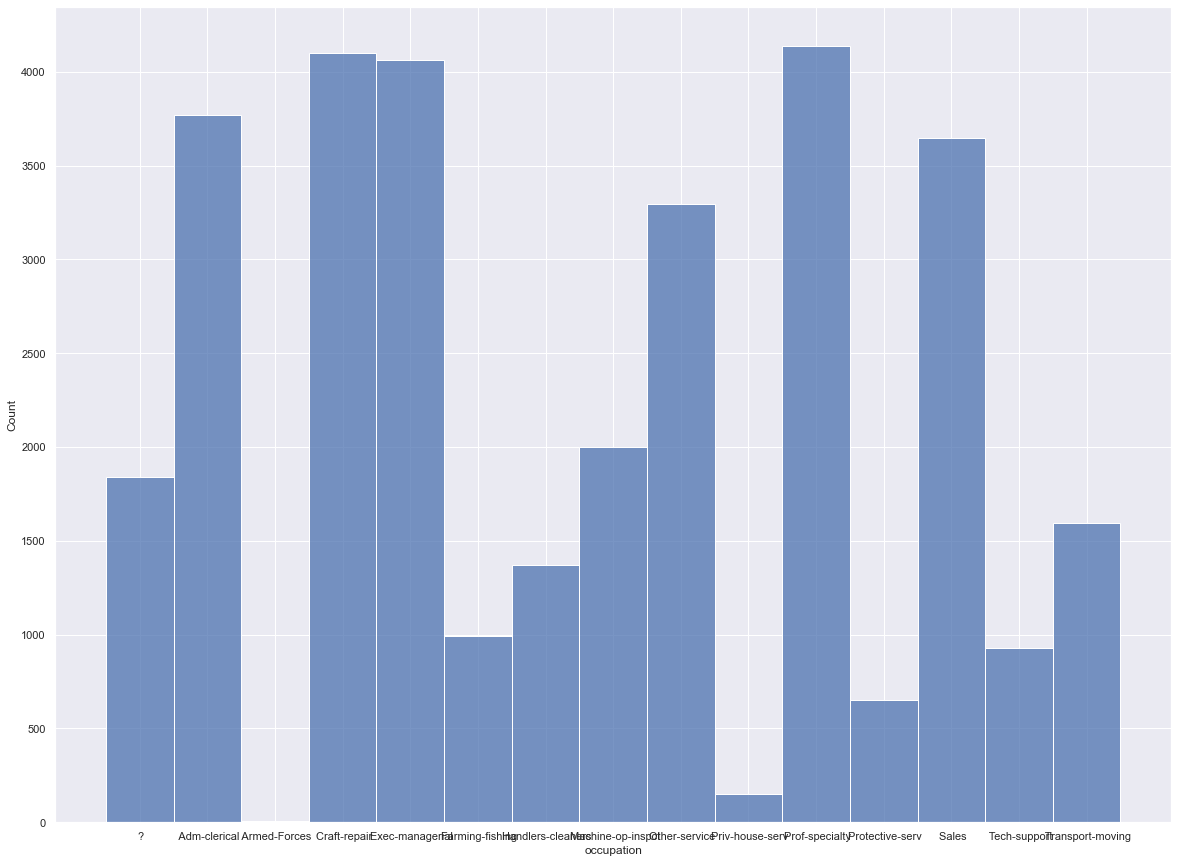

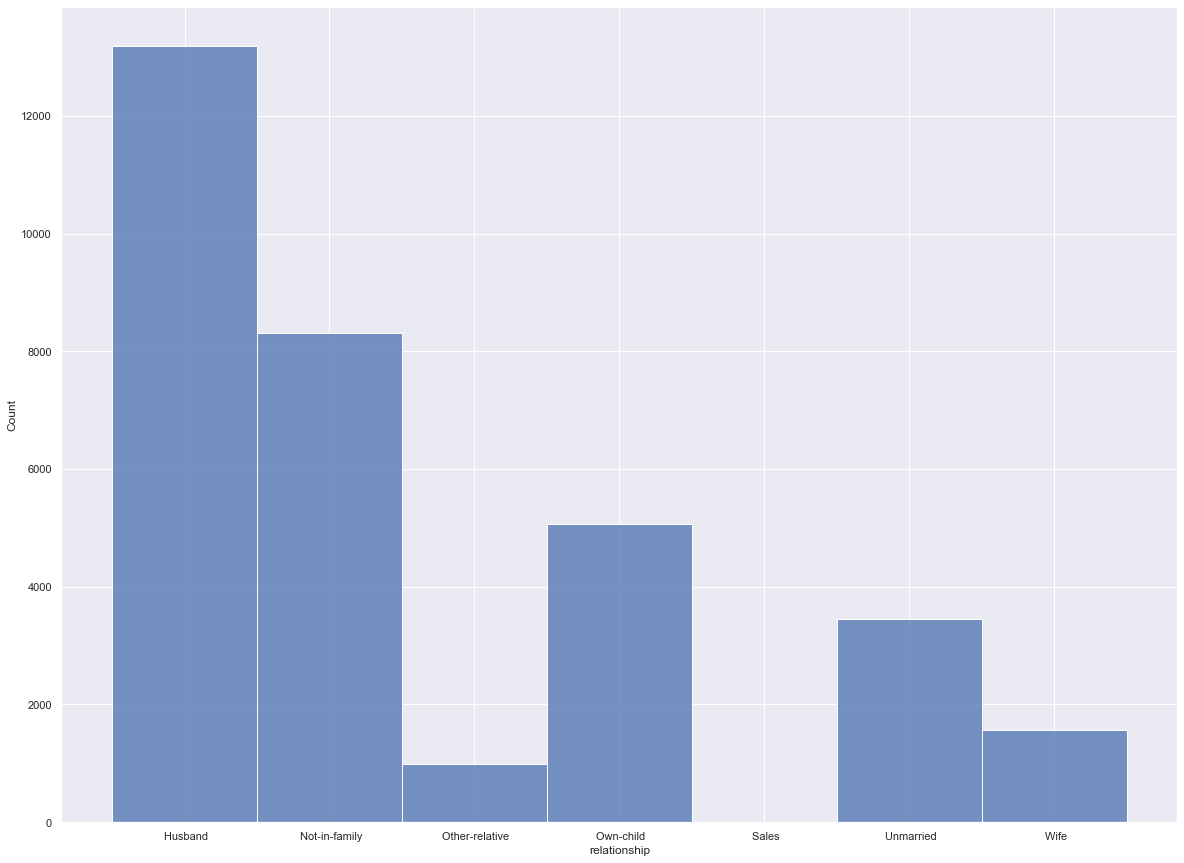

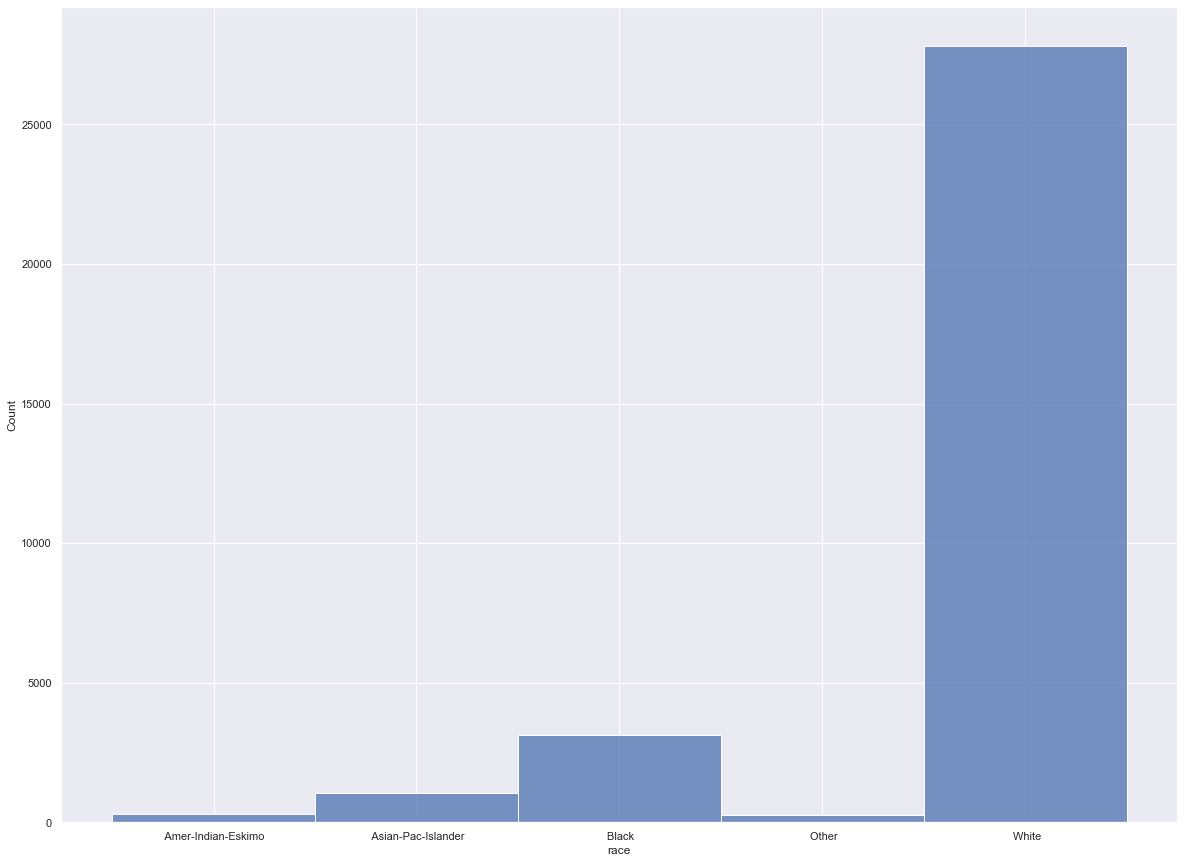

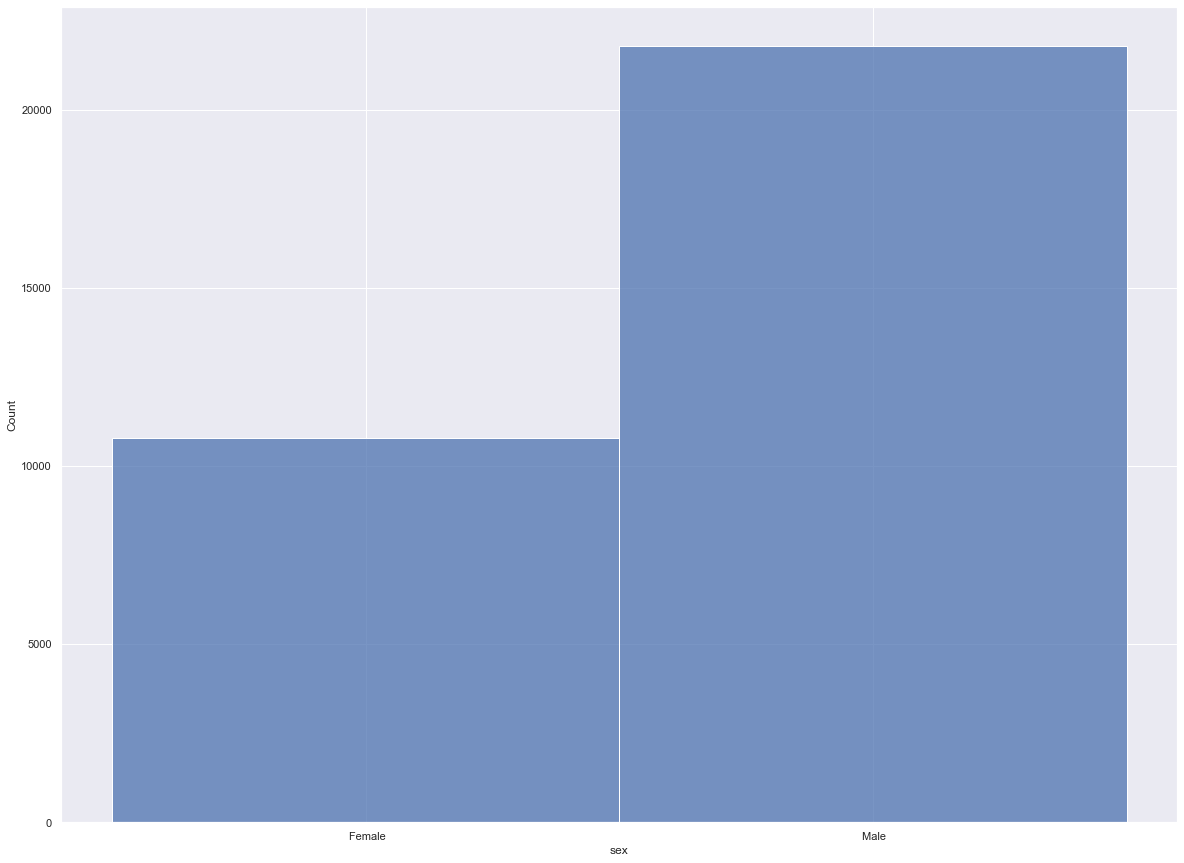

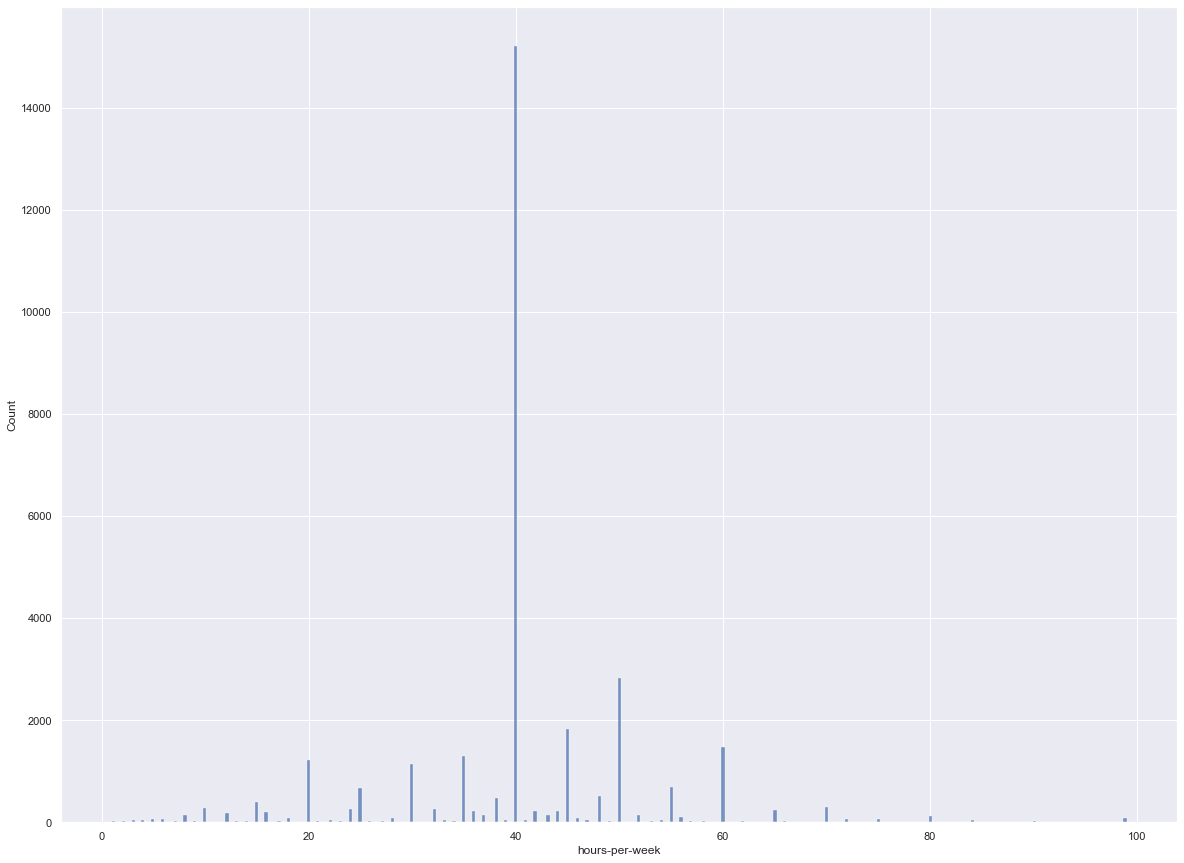

In [29]:
for i, col in enumerate(new_train_data.columns):
    if col not in ['final_weight', 'cap-gain', 'cap-loss', 'comparison', 'native-country']:
        plt.figure(i)
        sns.histplot(data=new_train_data, x=col)